# Exercises

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

In [1]:
import os
import shutil
import sys
import warnings
from pathlib import Path

import caiman as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf import params as params

sys.path.append(os.path.abspath("code"))

import auxiliary_functions as aux
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

palette = sns.color_palette("tab10")

sns.set_theme("paper", palette=palette, style="whitegrid", font_scale=1.5, font="Times")

In [2]:
input_tif_file_path = 'data/caiman_video_trial_0.tif'

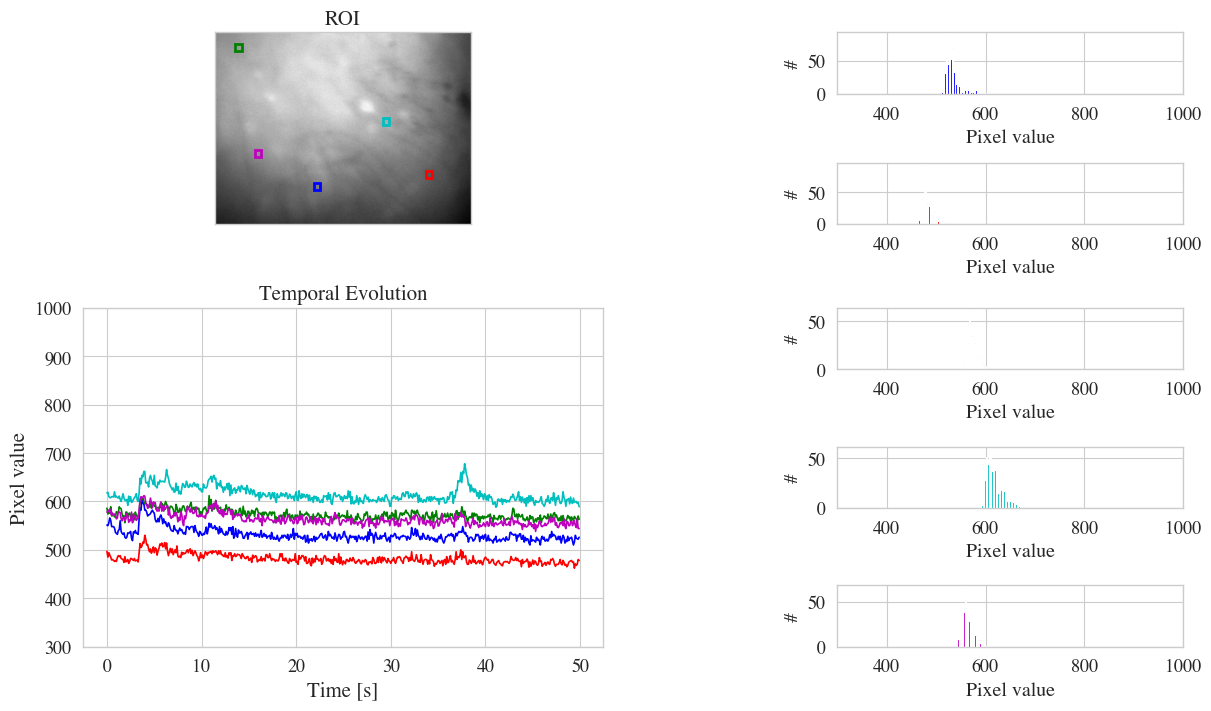

In [3]:
aux.temporal_evolution(file_name=input_tif_file_path, output_file_name='imgs/pixel_temporal_evolution.png')

In the above plot, we can see calcium traces from some pixels. Some regions (e.g., cyan and blue) exhibit higher intensity and distinct transients, indicating potential neuronal activity, while others (e.g., red and green) are relatively flat and low in intensity, characteristic of background or neuropil. These differences in temporal dynamics and intensity distributions can help distinguish active neuronal pixels from background pixels.

However, working directly with pixel-level traces is problematic due to noise, low SNR, and spatial spread of calcium signals. Individual pixels may partially capture signals from multiple sources, making them unreliable. Source extraction algorithms, like CNMF, denoise the data, deconvolve neural activity, and segment spatial footprints, allowing robust neuron identification and separation of overlapping signals. They also exploit both spatial and temporal correlations, which pixel-wise analysis ignores. Furthermore, working at the pixel level prevents demixing overlapping sources, especially in dense populations. Hence, although raw traces reveal some activity, source extraction is essential for reliable and interpretable population-level analysis.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


### Space filtering

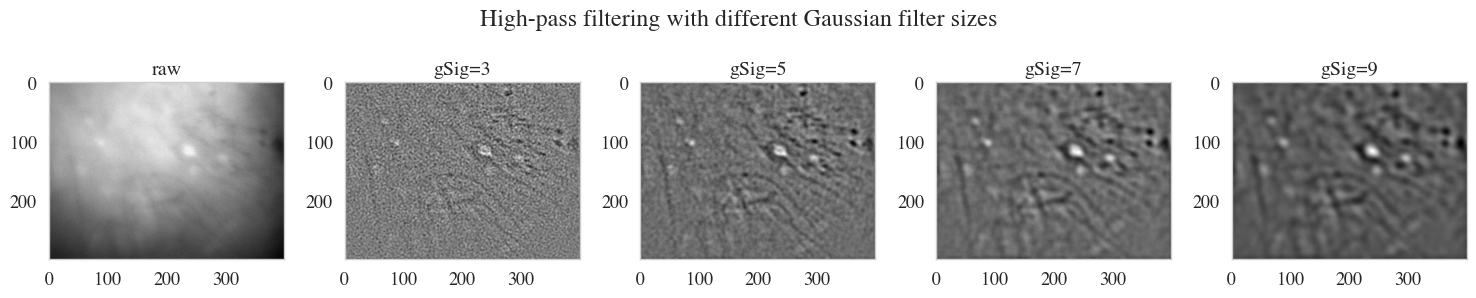

In [4]:
original_movie = cm.load(input_tif_file_path)
frame = original_movie[0]
gSigs = [(3, 3), (5, 5), (7, 7), (9, 9)]

fig, axs = plt.subplots(1, len(gSigs) + 1 , figsize=(15, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('raw')
axs[0].grid(False)
for k, g in enumerate(gSigs, start=1):
    f = high_pass_filter_space(frame, gSig_filt=g)
    axs[k].imshow(f, cmap='gray')
    axs[k].set_title(f'gSig={g[0]}')
    axs[k].grid(False)
plt.suptitle('High-pass filtering with different Gaussian filter sizes', y=0.85)
plt.tight_layout()

In the above plot, we can see that increasing the Gaussian filter size (gSig) smooths over larger spatial regions, leading to stronger background subtraction and highlighting more prominent features, which can aid in detecting finer details. However, if gSig is too large (le.g. 7 and 9), it suppresses meaningful structures, blurs the image, and amplify noise-like artifacts.

Since crispness is often quantified as the L2 norm of the image gradient, high-pass filtering with increasing gSig will initially increase crispness by enhancing edges and local contrast. However, beyond an optimal gSig, overly aggressive filtering may suppress meaningful structure, leading to a plateau or even reduction in crispness.

### Motion correction with base parameters configuration

In [5]:
#### Base motion correction parameters configuration ####
base_params = {
    'pw_rigid': True,
    'gSig_filt': (5, 5),
    'max_shifts': (25, 25),
    'niter_rig': 1,
    'strides': (48, 48),
    'overlaps': (96, 96),
    'upsample_factor_grid': 1,
    'num_frames_split': 80,
    'max_deviation_rigid': 15,
    'shifts_opencv': True,
    'use_cuda': False,
    'nonneg_movie': True,
    'border_nan': 'copy'
}
base_params['min_mov'] = np.min(original_movie)

# Setup parallelization
cm.cluster.stop_server()
c, dview, n_proc = cm.cluster.setup_cluster(backend='multiprocessing', n_processes=psutil.cpu_count(), single_thread=False)

In [6]:
# Pass parameters to the motion correction class
opts = params.CNMFParams(params_dict=base_params)

Path("data/motion_corrected").mkdir(parents=True, exist_ok=True)

# Perform motion correction
mc = MotionCorrect(input_tif_file_path, dview=dview, **opts.get_group('motion'))
# Rigid motion correction
mc.motion_correct_rigid(save_movie=True)
# Pw-rigid motion correction
mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig)
fname_tot_els = mc.fname_tot_els[0]

m_els = cm.load(fname_tot_els)
fname_tot_els = m_els.save('motion_corrected_video.mmap',  order='C')

fname_tot_els_name = Path(fname_tot_els).name
shutil.move(str(fname_tot_els), f"data/motion_corrected/{fname_tot_els_name}")

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'

### Factors that affect Pw-rigid motion correction

According to Pnevmatikakis et al., beside **Gaussian filter size**, **patch size** and **the amount of overlap** are two of most important factors. They said that the value selection for these two factors should (i) must be large enough to contain sufficient neuronal structures or features, while (ii) at the same time, patches must be small enough so that within each, the motion can be well-approximated as rigid.

Another important factor is **upsample_factor_grid**. Higher values reduce shift differences between neighboring patches, minimizing interpolation-induced smearing. However, excessive upsampling increases computational cost without proportionate gains in typical cases.

In this notebook, I focus on experimenting with **Gaussian filter size**, **patch size** and **the amount of overlap** and investigating how these factors empirically affect motion correction using cripsness as a metric.

### Experiment 2.1: Changing Gaussian filter size

In [7]:
#### Experiment with different gSig_filt values ####
gSigs = [(1, 1), (3, 3), (5, 5), (7, 7), (9, 9)]

results = {'cr_rig': [], 'cr_els': []}
for g in gSigs:
    p = base_params.copy()
    p['gSig_filt'] = g
    opts = params.CNMFParams(params_dict=p)

    # Perform motion correction
    mc = MotionCorrect(input_tif_file_path, dview=dview, **opts.get_group('motion'))
    # Rigid motion correction
    mc.motion_correct_rigid(save_movie=True)
    # Pw-rigid motion correction
    mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig)

    # Compute cripsness
    rigid_path = mc.fname_tot_rig[0]
    els_path = mc.fname_tot_els[0]
    height, width = mc.total_template_els.shape
    _, _, _, _, cr_rig = cm.motion_correction.compute_metrics_motion_correction(
        rigid_path, height, width,
        swap_dim=False, winsize=100, play_flow=False, resize_fact_flow=0.1)
    _, _, _, _, cr_els = cm.motion_correction.compute_metrics_motion_correction(
        els_path, height, width,
        swap_dim=False, winsize=100, play_flow=False, resize_fact_flow=0.1)

    results['cr_rig'].append(cr_rig)
    results['cr_els'].append(cr_els)

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParam

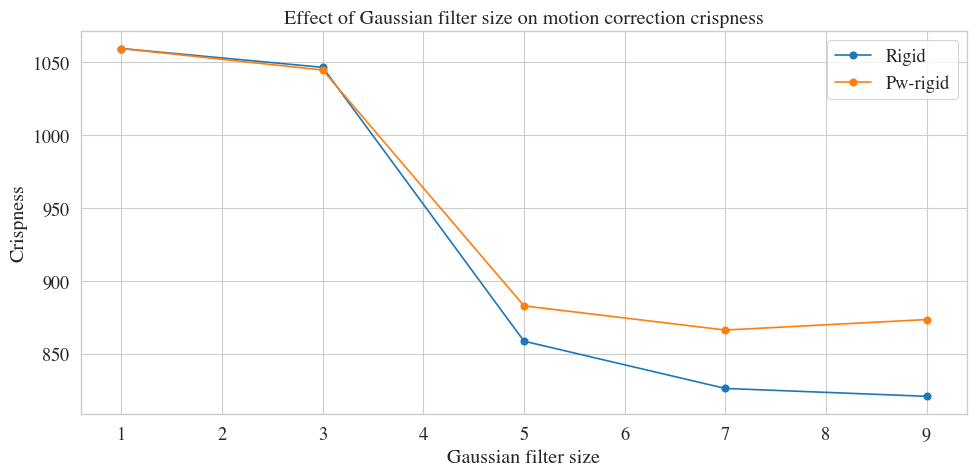

In [8]:
#### Plot cripsness vs. gSig_filt ####
g_vals = [g[0] for g in gSigs]
plt.figure(figsize=(10, 5))
plt.plot(g_vals, results['cr_rig'], marker='o', label='Rigid')
plt.plot(g_vals, results['cr_els'], marker='o', label='Pw-rigid')
plt.xlabel('Gaussian filter size')
plt.ylabel('Crispness')
plt.title('Effect of Gaussian filter size on motion correction crispness')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The above plot shows that motion correction crispness decreases as the Gaussian filter size increases, for both rigid and pw-rigid methods. This indicates that larger spatial filters excessively smooth the data, reducing the local contrast needed for accurate alignment. At smaller filter sizes (e.g., gSig = 1–3), both methods yield higher crispness, with pw-rigid slightly outperforming rigid correction. Beyond gSig = 5, crispness stabilizes or slightly improves for pw-rigid, while it continues to reduce significantly for rigid correction. This suggests that pw-rigid correction is more robust to the choice of spatial filter size, likely due to its finer motion modeling.

### Experiment 2.2: Changing patch size (strides)

In [9]:
#### Experiment with different patch size ####
stride_list = [(16, 16), (32, 32), (48, 48), (64, 64), (80, 80)]
results = {'cr_rig': [], 'cr_els': []}

for s in stride_list:
    p = base_params.copy()
    p['strides'] = s
    opts = params.CNMFParams(params_dict=p)

    # Perform motion correction
    mc = MotionCorrect(input_tif_file_path, dview=dview, **opts.get_group('motion'))
    # Rigid motion correction
    mc.motion_correct_rigid(save_movie=True)
    # Pw-rigid motion correction
    mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig)

    # Compute cripsness
    rigid_path = mc.fname_tot_rig[0]
    els_path = mc.fname_tot_els[0]
    height, width = mc.total_template_els.shape
    _, _, _, _, cr_rig = cm.motion_correction.compute_metrics_motion_correction(
        rigid_path, height, width,
        swap_dim=False, winsize=100, play_flow=False, resize_fact_flow=0.1)
    _, _, _, _, cr_els = cm.motion_correction.compute_metrics_motion_correction(
        els_path, height, width,
        swap_dim=False, winsize=100, play_flow=False, resize_fact_flow=0.1)

    results['cr_rig'].append(cr_rig)
    results['cr_els'].append(cr_els)

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParam

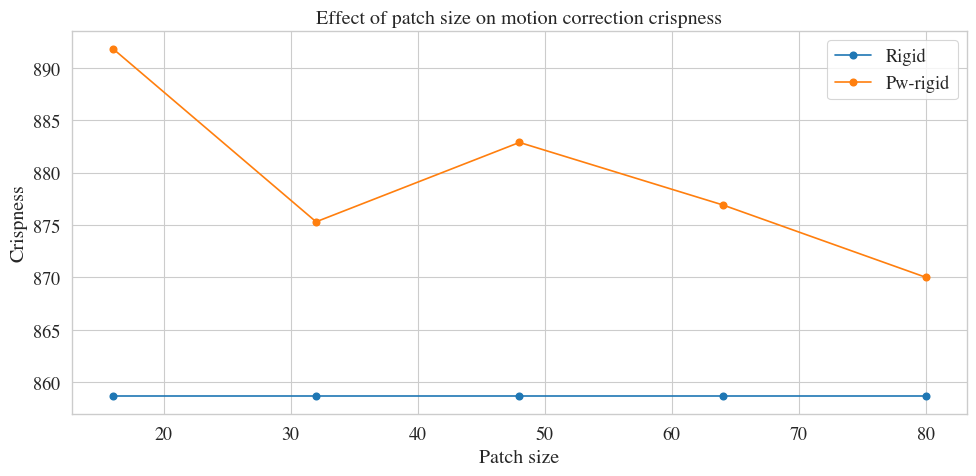

In [10]:
#### Plot cripsness vs. stride ####
stride_vals = [s[0] for s in stride_list]
plt.figure(figsize=(10, 5))
plt.plot(stride_vals, results['cr_rig'], marker='o', label='Rigid')
plt.plot(stride_vals, results['cr_els'], marker='o', label='Pw-rigid')
plt.xlabel('Patch size')
plt.ylabel('Crispness')
plt.title('Effect of patch size on motion correction crispness')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

This plot demonstrates that patch size has a notable effect on motion correction crispness for pw-rigid correction, but not for rigid correction. Crispness for rigid motion correction remains constant across patch sizes, as expected, since rigid correction does not involve spatial partitioning. For pw-rigid, the highest crispness is observed at the smallest patch size (16), suggesting finer local alignment. However, crispness drops at 32, peaks again around 48, and then gradually decreases, indicating a trade-off between capturing local deformations and maintaining sufficient signal for registration. These results align with Pnevmatikakis et al. claim, which is pw-rigid patches must be small enough to capture non-rigid motion but large enough to preserve reliable signal features.

### Experiment 2.3: Changing the amount of overlap

In [11]:
#### Experiment with different amount of overlap ####
overlaps = [(16, 16), (32, 32), (48, 48), (64, 64), (96, 96)]
results = {'cr_rig': [], 'cr_els': []}

for o in overlaps:
    p = base_params.copy()
    p['overlaps'] = o
    opts = params.CNMFParams(params_dict=p)

    # Perform motion correction
    mc = MotionCorrect(input_tif_file_path, dview=dview, **opts.get_group('motion'))
    # Rigid motion correction
    mc.motion_correct_rigid(save_movie=True)
    # Pw-rigid motion correction
    mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig)

    # Compute cripsness
    rigid_path = mc.fname_tot_rig[0]
    els_path = mc.fname_tot_els[0]
    height, width = mc.total_template_els.shape
    _, _, _, _, cr_rig = cm.motion_correction.compute_metrics_motion_correction(
        rigid_path, height, width,
        swap_dim=False, winsize=100, play_flow=False, resize_fact_flow=0.1)
    _, _, _, _, cr_els = cm.motion_correction.compute_metrics_motion_correction(
        els_path, height, width,
        swap_dim=False, winsize=100, play_flow=False, resize_fact_flow=0.1)

    results['cr_rig'].append(cr_rig)
    results['cr_els'].append(cr_els)

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParam

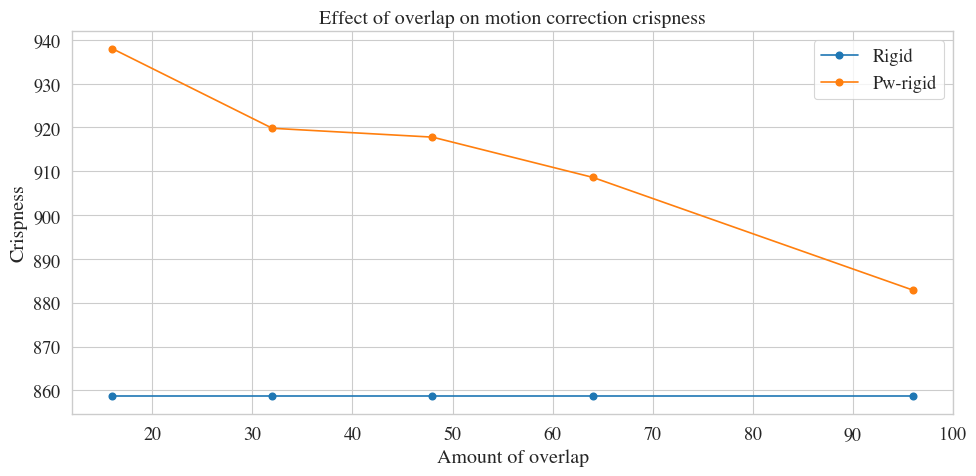

In [12]:
#### Plot cripsness vs. amount of overlap ####
overlap_vals = [o[0] for o in overlaps]
plt.figure(figsize=(10, 5))
plt.plot(overlap_vals, results['cr_rig'], marker='o', label='Rigid')
plt.plot(overlap_vals, results['cr_els'], marker='o', label='Pw-rigid')
plt.xlabel('Amount of overlap')
plt.ylabel('Crispness')
plt.title('Effect of overlap on motion correction crispness')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

This plot shows that increasing the amount of overlap between patches in pw-rigid motion correction leads to a consistent decrease in crispness, likely due to interpolation-induced smoothing in the overlapping regions. Lower overlap (e.g., 16–32 pixels) yields better alignment quality, minimizing smearing while maintaining continuity. In contrast, crispness remains constant across overlap values for rigid correction, as expected. These results support the recommendation to keep overlap moderate to avoid degradation of image sharpness in pw-rigid correction, aligns with Pnevmatikakis et al. study.

## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.

In [13]:
# Load motion corrected video
input_mmap_file_path = 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F')

In [14]:
#### Base source extraction parameters configuration ####
base_params_source_extraction = {'fr': 10,
                                'decay_time': 0.1,
                                'min_corr': 0.7,
                                'min_pnr': 7,
                                'p': 1,
                                'K': None,
                                'gSig': (4, 4),
                                'gSiz': (17, 17),
                                'ring_size_factor': 1.4,
                                'merge_thr': 0.7, 'rf': 60,
                                'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                                'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2,
                                'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                                'update_background_components': True,
                                'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                                'del_duplicates': True, 'only_init': True}

### Experiment 3.1: Changing minimum PNR

In [15]:
#### Experiment with minimum PNR ####
min_pnr_values = [7, 9, 11, 13]
fixed_corr = 0.6
records = []
cnmf_objects = {}

for pnr in min_pnr_values:
    p = base_params_source_extraction.copy()
    p['min_pnr'] = pnr
    p['min_corr'] = fixed_corr
    opts = params.CNMFParams(params_dict=p)

    # Perform source extraction
    cnmf_obj = cnmf.CNMF(n_processes=n_proc, dview=dview, params=opts)
    cnmf_obj.fit(images)

    # Compute number of neurons and sparsity
    A = cnmf_obj.estimates.A
    num_neurons = A.shape[1]
    nnz = np.array(A.getnnz(axis=0))
    sparsity = (nnz / A.shape[0]).mean()

    # Store results
    records.append({
        'parameter':   'min_pnr',
        'value':       pnr,
        'num_neurons': num_neurons,
        'sparsity':    sparsity
    })
    cnmf_objects[f'minpnr_{pnr}'] = cnmf_obj

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.a

### Experiment 3.2: Changing minimum correlation

In [16]:
#### Experiment with minimum correlation values ####
min_corr_values = [0.6, 0.7, 0.8, 0.9]
fixed_pnr = 7

for mc in min_corr_values:
    p = base_params_source_extraction.copy()
    p['min_corr'] = mc
    p['min_pnr'] = fixed_pnr
    opts = params.CNMFParams(params_dict=p)

    # Perform source extraction
    cnmf_obj = cnmf.CNMF(n_processes=n_proc, dview=dview, params=opts)
    cnmf_obj.fit(images)

    # Compute number of neurons and sparsity
    A = cnmf_obj.estimates.A
    num_neurons = A.shape[1]
    nnz = np.array(A.getnnz(axis=0))
    sparsity = (nnz / A.shape[0]).mean()

    # Store results
    records.append({
        'parameter':   'min_corr',
        'value':       mc,
        'num_neurons': num_neurons,
        'sparsity':    sparsity
    })
    cnmf_objects[f'mincorr_{mc}'] = cnmf_obj

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/anhkhoa/conda/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_dia.py:298: RuntimeWarning: divide by zero encountered in remainder
  c = np.a

### Result interpretation

In [17]:
df = pd.DataFrame(records)
df

,parameter,value,num_neurons,sparsity
0,min_pnr,7.0,28,0.008188
1,min_pnr,9.0,11,0.008942
2,min_pnr,11.0,8,0.009823
3,min_pnr,13.0,6,0.007064
4,min_corr,0.6,28,0.008188
5,min_corr,0.7,24,0.008817
6,min_corr,0.8,21,0.009458
7,min_corr,0.9,19,0.009093


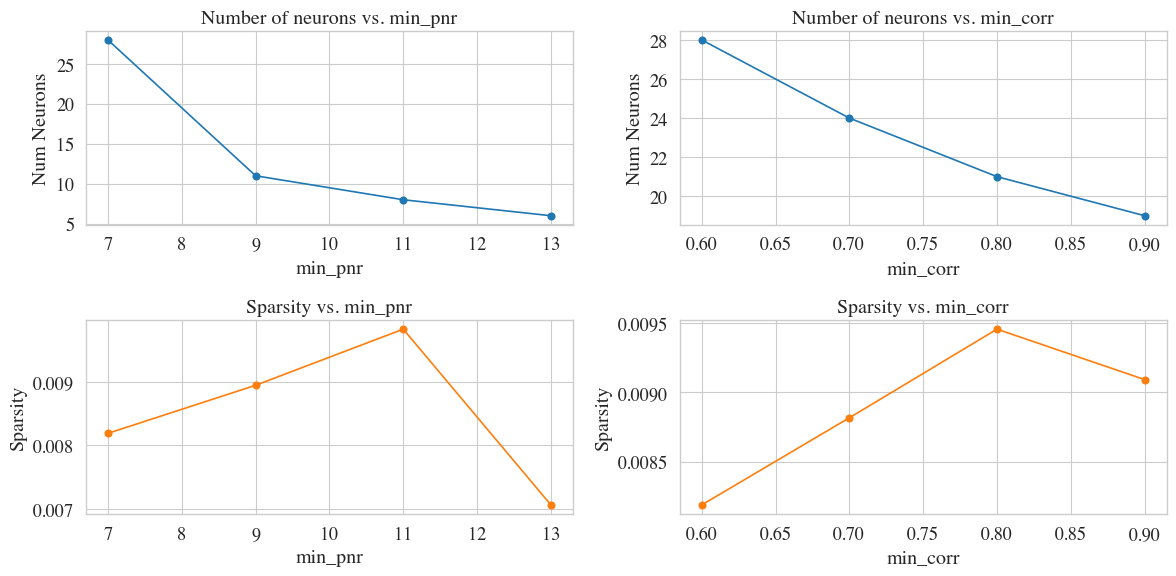

In [18]:
# Plot number of neurons vs. min_pnr and min_corr
_, axs = plt.subplots(2, 2, figsize=(12, 6))
params = ['min_pnr', 'min_corr']
metrics = ['num_neurons', 'sparsity']
colors = ['tab:blue', 'tab:orange']

for i, metric in enumerate(metrics):
    for j, param in enumerate(params):
        data = df[df['parameter'] == param]
        axs[i, j].plot(data['value'], data[metric], marker='o', color=colors[i], label=metric)
        title_prefix = 'Number of neurons' if metric == 'num_neurons' else 'Sparsity'
        axs[i, j].set_title(f'{title_prefix} vs. {param}')
        axs[i, j].set_xlabel(param)
        axs[i, j].set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()

In the above plot, we can see that increasing either min_pnr or min_corr thresholds reduces the number of detected neurons but generally increases spatial sparsity up to a point, indicating fewer but more spatially localized components. The highest number of neurons is obtained at the lowest thresholds: min_pnr = 7 and min_corr = 0.6. However, detecting the maximal number of neurons is not always better, as lower thresholds can introduce false positives and less spatially compact components. Optimal parameter selection balances sensitivity with spatial specificity to ensure that extracted components are both numerous and biologically meaningful.

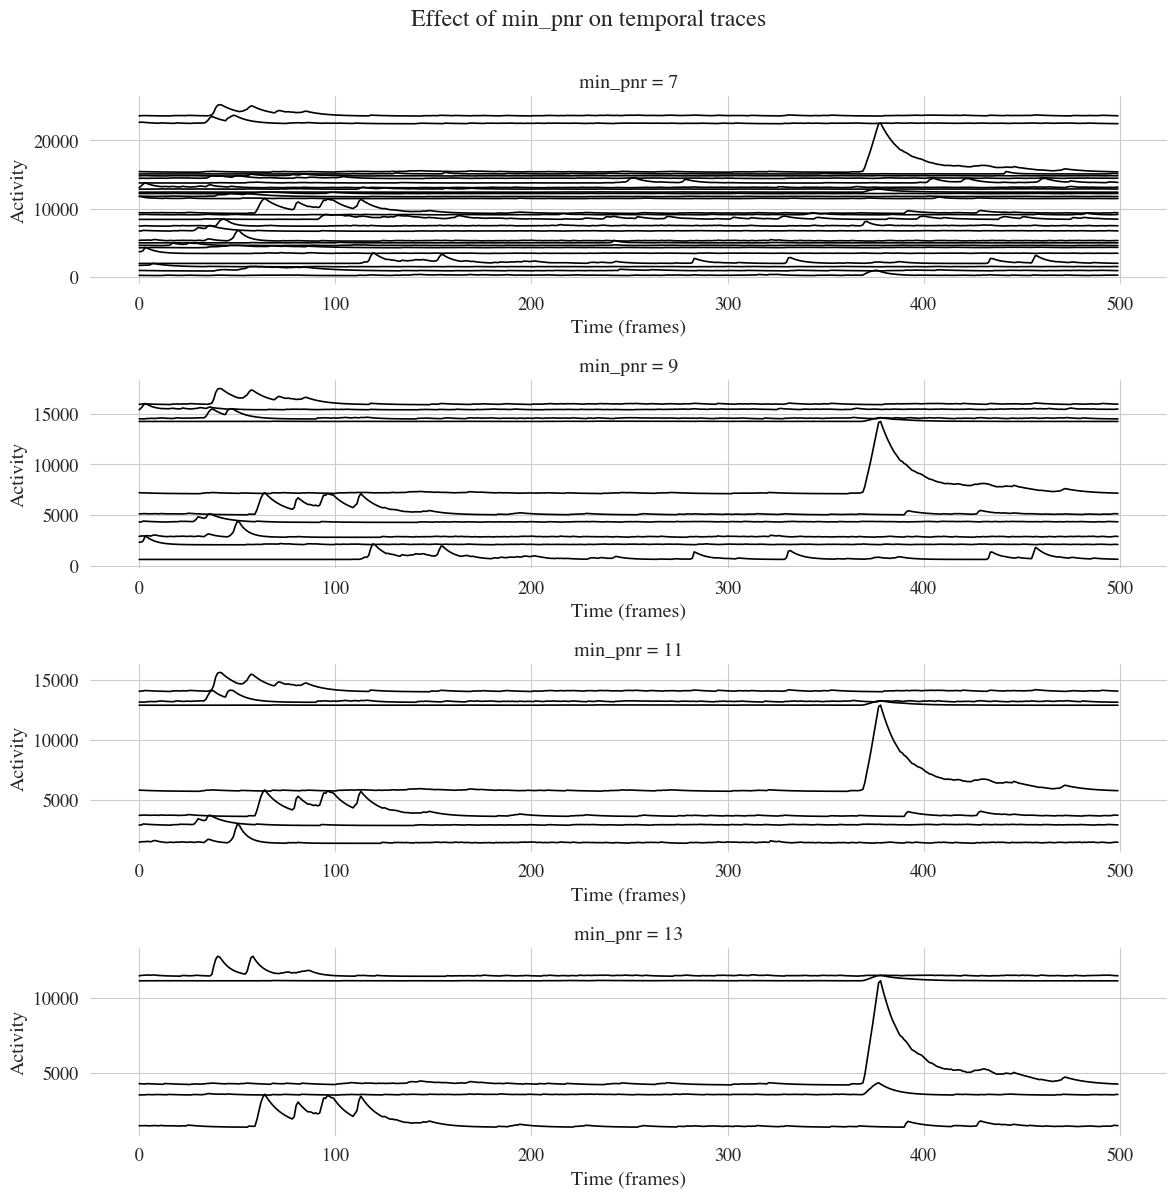

In [19]:
# Plot temporal traces vs. min_pnr
fig, axs = plt.subplots(len(min_pnr_values), 1, figsize=(12, 3*len(min_pnr_values)),)
for ax, pnr in zip(axs, min_pnr_values):
    obj = cnmf_objects[f'minpnr_{pnr}']
    C = obj.estimates.C.copy()
    C[1] += C[0].min()
    for i in range(1, C.shape[0]):
        C[i] += C[i].min() + C[:i].max()
    for i in range(1, C.shape[0]):
        ax.plot(C[i], c='k')
    ax.set_title(f'min_pnr = {pnr}')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Activity')
    sns.despine(ax=ax, left=True, bottom=True)
fig.suptitle('Effect of min_pnr on temporal traces', y=1.0)
plt.tight_layout()
plt.show()

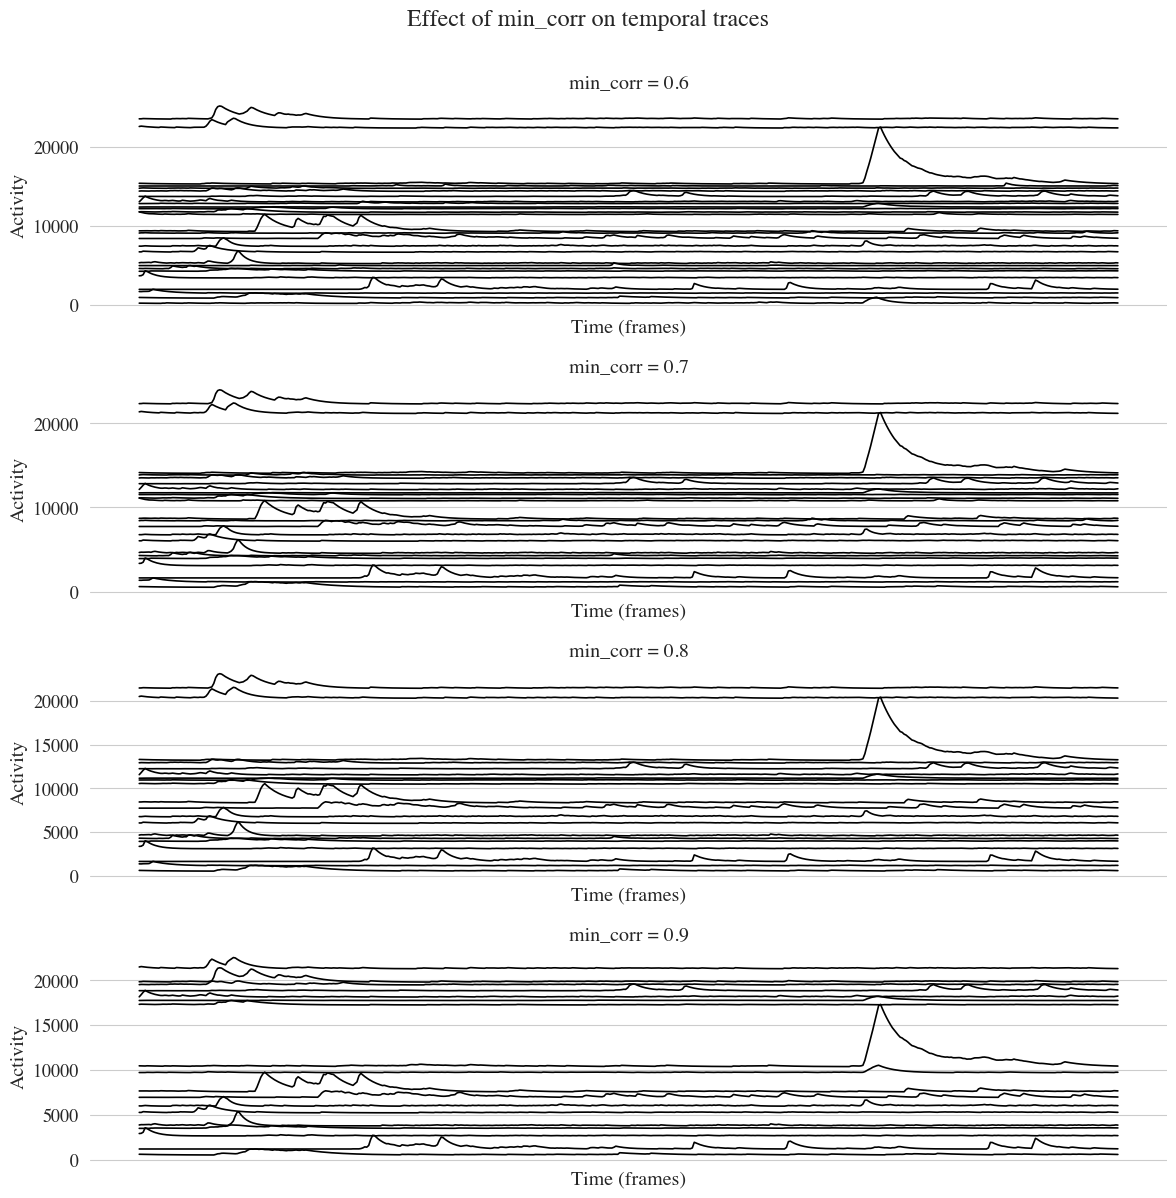

In [20]:
# Plot temporal traces vs. min_corr
fig, axs = plt.subplots(len(min_corr_values), 1, figsize=(12, 3*len(min_corr_values)))
for ax, mc in zip(axs, min_corr_values):
    obj = cnmf_objects[f'mincorr_{mc}']
    C = obj.estimates.C.copy()
    C[1] += C[0].min()
    for i in range(1, C.shape[0]):
        C[i] += C[i].min() + C[:i].max()
    for i in range(1, C.shape[0]):
        ax.plot(C[i], c='k')
    ax.set_title(f'min_corr = {mc}')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Activity')
    ax.set_xticks([])
    sns.despine(ax=ax, left=True, bottom=True)
fig.suptitle('Effect of min_corr on temporal traces', y=1.0)
plt.tight_layout()
plt.show()

In the above two plots, it is obvious that the temporal traces are clearly affected by both min_pnr and min_corr thresholds. In both plots, increasing these thresholds results in fewer extracted components, as seen by the decreasing number of traces. In the min_pnr plots (left), lower thresholds (e.g. 7) include more traces, but many are low in amplitude or noisy, indicating potential false positives. As min_pnr increases, weaker signals are excluded, yielding cleaner but fewer traces with higher signal-to-noise ratio.

Similarly, in the temporal trace vs. min_corr plot, higher correlation thresholds progressively eliminate components with weaker or less coherent spatial features, also improving the clarity of retained traces. However, excessively high thresholds (e.g. 0.9) may discard true neurons with slightly noisier or less correlated signals. Thus, while higher thresholds improve trace quality, they reduce sensitivity. 

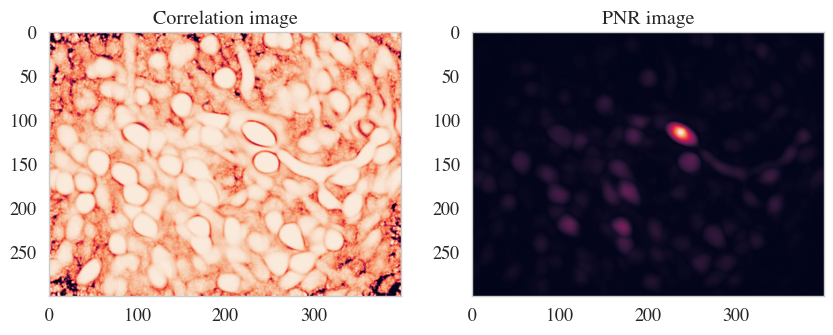

In [21]:
# Compute correlation and pnr images
gSig = 9
corr_image, pnr_image = cm.summary_images.correlation_pnr(images, gSig=gSig, swap_dim=False)

figure, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(corr_image)
axs[0].set_title('Correlation image')
axs[0].grid(False)
axs[1].imshow(pnr_image)
axs[1].set_title('PNR image')
axs[1].grid(False)

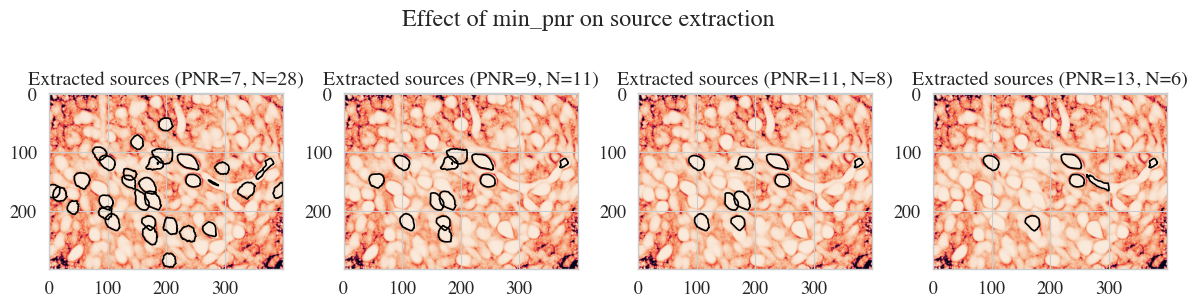

In [22]:
# Plot source extraction vs. min_pnr
fig, axs = plt.subplots(1, len(min_pnr_values), figsize=(3 * len(min_pnr_values), 5))

for ax, pnr in zip(axs, min_pnr_values):
    cnmf_obj = cnmf_objects[f'minpnr_{pnr}']
    pos = ax.imshow(corr_image)
    coordinates = cm.utils.visualization.get_contours(cnmf_obj.estimates.A, np.shape(corr_image), 0.2, 'max')
    for c in coordinates:
        v = c['coordinates']
        c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                        np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
        ax.plot(*v.T, c='k')
    ax.set_title(f'Extracted sources (PNR={pnr}, N={cnmf_obj.estimates.A.shape[1]})')
plt.suptitle('Effect of min_pnr on source extraction', y=0.8)
plt.tight_layout()
plt.show()

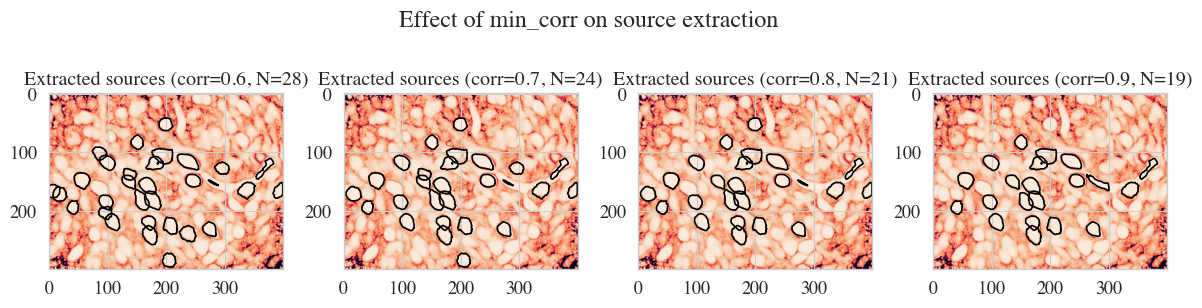

In [24]:
# Plot sources extraction vs. min_corr
fig, axs = plt.subplots(1, len(min_corr_values), figsize=(3 * len(min_corr_values), 5))

for ax, mc in zip(axs, min_corr_values):
    cnmf_obj = cnmf_objects[f'mincorr_{mc}']
    pos = ax.imshow(corr_image, aspect='equal')
    coordinates = cm.utils.visualization.get_contours(cnmf_obj.estimates.A, np.shape(corr_image), 0.2, 'max')
    for c in coordinates:
        v = c['coordinates']
        c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                     np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
        ax.plot(*v.T, c='k')
    ax.set_title(f'Extracted sources (corr={mc}, N={cnmf_obj.estimates.A.shape[1]})')
plt.suptitle('Effect of min_corr on source extraction', y=0.8)
plt.tight_layout()
plt.show()

These source extraction visualization gives us a better insight into the effect of both min_pnr and min_corr on the performance of source extraction algorithm. We can see that, as either parameter increases, the number of detected sources (N) decreases. At lower thresholds (e.g., pnr=7, corr=0.6), more sources are detected, but some may be false positives or low-SNR components. Higher thresholds (e.g., pnr=13, corr=0.9) yield fewer but more spatially distinct and compact sources, suggesting improved specificity. Therefore, tuning these parameters controls the trade-off between sensitivity (more detections) and specificity (fewer, cleaner components).